In [ ]:
import os
import pandas as pd
import numpy as np
import json
import logging
import pickle
from tqdm import tqdm
import re
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("data_preprocessing.log"),
        logging.StreamHandler()
    ]
)


nltk.download('vader_lexicon', quiet=True)


base_dir = "/content" 
csv_data_path = "/content/movies_data.csv"  
poster_images_dir = "/content/drive/MyDrive/posters"  
processed_data_dir = "/content/processed_data"  


os.makedirs(processed_data_dir, exist_ok=True)
os.makedirs(os.path.join(processed_data_dir, "splits"), exist_ok=True)


TOP_GENRES = [
    'Drama', 'Comedy', 'Thriller', 'Action', 'Romance',
    'Horror', 'Adventure', 'Crime', 'Science Fiction', 'Family'
]


def load_movie_data(file_path):
  
    logging.info(f"Loading movie data from: {file_path}")

    try:
        df = pd.read_csv(file_path)
        logging.info(f"Loaded {len(df)} movies from CSV")


        required_columns = ['id', 'title', 'overview']
        missing_columns = [col for col in required_columns if col not in df.columns]

        if missing_columns:
            logging.warning(f"CSV is missing required columns: {missing_columns}")


        logging.info("Sample data:")
        logging.info(df.head())
        logging.info(f"Columns: {df.columns.tolist()}")

        return df

    except Exception as e:
        logging.error(f"Error loading CSV file: {e}")
        raise

def extract_features(df):
  
    logging.info("Extracting features from dataset...")


    processed_df = df.copy()

    # Extract or process genre information
    if 'genres' in processed_df.columns:
        # Try to parse genre information if it's stored as a string
        if processed_df['genres'].dtype == 'object' and isinstance(processed_df['genres'].iloc[0], str):
            try:
                # Try to parse genres column as JSON or string list
                processed_df['genres'] = processed_df['genres'].apply(
                    lambda x: json.loads(x.replace("'", "\"")) if isinstance(x, str) else x
                )
            except Exception as e:
                logging.warning(f"Failed to parse genres as JSON: {e}")

                # Try to extract genres from string format like "[{'id': 12, 'name': 'Adventure'}, ...]"
                try:
                    def extract_genre_names(genre_str):
                        if not isinstance(genre_str, str):
                            return []
                        pattern = r"'name'\s*:\s*'([^']+)'"
                        matches = re.findall(pattern, genre_str)
                        return matches

                    processed_df['genres'] = processed_df['genres'].apply(extract_genre_names)
                except Exception as e:
                    logging.warning(f"Failed to extract genre names with regex: {e}")

        # Create 'groups' column expected by the model
        processed_df['groups'] = processed_df['genres'].apply(
            lambda x: [genre['name'] for genre in x] if isinstance(x, list) and
                      all(isinstance(g, dict) and 'name' in g for g in x) else
            x if isinstance(x, list) else []
        )

    # Calculate title length
    processed_df['title_length'] = processed_df['title'].apply(
        lambda x: len(str(x)) if pd.notna(x) else 0
    )

    # Calculate overview length
    processed_df['overview_length'] = processed_df['overview'].apply(
        lambda x: len(str(x)) if pd.notna(x) and isinstance(x, str) else 0
    )

    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Title sentiment
    processed_df['title_sentiment'] = processed_df['title'].apply(
        lambda x: sia.polarity_scores(str(x))['compound'] if pd.notna(x) else 0
    )

    # Overview sentiment
    processed_df['overview_sentiment'] = processed_df['overview'].apply(
        lambda x: sia.polarity_scores(str(x))['compound'] if pd.notna(x) and isinstance(x, str) else 0
    )

    # Add vote_average if not present (used as a feature by the model)
    if 'vote_average' not in processed_df.columns:
        # Use a default value or another field if available
        if 'rating' in processed_df.columns:
            processed_df['vote_average'] = processed_df['rating']
        else:
            processed_df['vote_average'] = 5.0  # Default middle value
            logging.warning("Adding default vote_average of 5.0")

    # Filter out movies without overviews or genres
    valid_df = processed_df[
        processed_df['overview'].notna() &
        (processed_df['overview_length'] > 10) &
        processed_df['groups'].apply(lambda x: len(x) > 0)
    ]

    logging.info(f"After filtering: {len(valid_df)} movies (removed {len(processed_df) - len(valid_df)})")

    # Log genre distribution
    genre_counts = {}
    for genres in valid_df['groups']:
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1

    logging.info("Genre distribution:")
    for genre, count in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True):
        logging.info(f"  {genre}: {count} movies ({count/len(valid_df)*100:.2f}%)")

    return valid_df

def filter_to_top_genres(df, top_genres):
    
    logging.info(f"Filtering to top {len(top_genres)} genres: {', '.join(top_genres)}")

    filtered_df = df.copy()

    # Keep only the top genres in each movie's genre list
    filtered_df['original_groups'] = filtered_df['groups'].copy()
    filtered_df['groups'] = filtered_df['groups'].apply(
        lambda x: [genre for genre in x if genre in top_genres]
    )

    # Remove movies that now have no genres in our top list
    before_count = len(filtered_df)
    filtered_df = filtered_df[filtered_df['groups'].apply(len) > 0]
    after_count = len(filtered_df)

    logging.info(f"Removed {before_count - after_count} movies without any of the top genres")
    logging.info(f"Retained {after_count} movies with at least one top genre")

    # Log the distribution of top genres after filtering
    genre_counts = {}
    total_movies = len(filtered_df)

    for genres in filtered_df['groups']:
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1

    logging.info("Genre distribution after filtering:")
    for genre in top_genres:
        count = genre_counts.get(genre, 0)
        percentage = (count / total_movies) * 100
        logging.info(f"  {genre}: {count} movies ({percentage:.2f}%)")

    return filtered_df

def match_posters_to_movies(df, poster_directory):
   
    logging.info("Matching poster files to movies...")

    # List all poster files
    poster_files = os.listdir(poster_directory)
    poster_files = [f for f in poster_files if f.endswith(('.jpg', '.jpeg', '.png'))]

    logging.info(f"Found {len(poster_files)} poster files in {poster_directory}")

    # Create a mapping of movie IDs to poster file paths
    id_to_poster = {}
    title_to_poster = {}

    # Check if posters are named by ID (e.g., 123.jpg)
    for poster_file in poster_files:
        file_base = os.path.splitext(poster_file)[0]

        # If file_base is numeric, it might be an ID
        if file_base.isdigit():
            id_to_poster[int(file_base)] = os.path.join(poster_directory, poster_file)
        else:
            # Try to match by movie title
            # E.g., "The_Avengers.jpg" -> "The Avengers"
            title_from_file = file_base.replace('_', ' ')
            title_to_poster[title_from_file.lower()] = os.path.join(poster_directory, poster_file)

    # Add poster path to dataframe
    df['poster_path'] = None

    # Try to match by ID first
    if 'id' in df.columns:
        match_count = 0
        for i, row in df.iterrows():
            movie_id = row['id']
            if movie_id in id_to_poster:
                df.at[i, 'poster_path'] = id_to_poster[movie_id]
                match_count += 1

        logging.info(f"Matched {match_count} posters by movie ID")

    # If still missing posters, try to match by title
    missing_posters = df['poster_path'].isna().sum()
    if missing_posters > 0 and 'title' in df.columns:
        match_count = 0
        for i, row in df.iterrows():
            if pd.isna(df.at[i, 'poster_path']):
                title = row['title']
                title_lower = title.lower()

                # Look for exact title match
                if title_lower in title_to_poster:
                    df.at[i, 'poster_path'] = title_to_poster[title_lower]
                    match_count += 1
                else:
                    # Try normalized title match (lowercase, no punctuation)
                    normalized_title = re.sub(r'[^\w\s]', '', title_lower)

                    for poster_key, poster_path in title_to_poster.items():
                        normalized_key = re.sub(r'[^\w\s]', '', poster_key)
                        if normalized_title == normalized_key:
                            df.at[i, 'poster_path'] = poster_path
                            match_count += 1
                            break

        logging.info(f"Matched {match_count} additional posters by movie title")

    # Count movies with matching posters
    matched_posters = df['poster_path'].notna().sum()
    logging.info(f"Matched {matched_posters} posters to movies ({matched_posters/len(df)*100:.2f}%)")

    return df

def filter_movies_with_posters(df):
    
    logging.info("Filtering dataset to only include movies with posters...")

    # Keep only rows with valid poster paths
    filtered_df = df[df['poster_path'].notna()]

    # Verify posters actually exist on disk
    filtered_df['poster_exists'] = filtered_df['poster_path'].apply(os.path.exists)
    final_df = filtered_df[filtered_df['poster_exists']]

    # Drop the temporary column
    final_df = final_df.drop(columns=['poster_exists'])

    logging.info(f"After filtering for posters: {len(final_df)} movies (removed {len(df) - len(final_df)})")

    return final_df

def verify_image_integrity(df):

    logging.info("Verifying poster image integrity...")

    valid_posters = []

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Checking poster images"):
        poster_path = row['poster_path']

        if pd.isna(poster_path) or not os.path.exists(poster_path):
            valid_posters.append(False)
            continue

        try:
            # Try to open the image to verify it's valid
            img = Image.open(poster_path)
            img.verify()  # Verify it's a valid image
            valid_posters.append(True)
        except Exception as e:
            logging.warning(f"Invalid image: {poster_path} - {e}")
            valid_posters.append(False)

    # Add validity flag to dataframe
    df['valid_poster'] = valid_posters

    # Count valid posters
    valid_count = sum(valid_posters)
    logging.info(f"Valid posters: {valid_count}/{len(df)} ({valid_count/len(df)*100:.2f}%)")

    # Filter to keep only movies with valid posters
    filtered_df = df[df['valid_poster']]
    filtered_df = filtered_df.drop(columns=['valid_poster'])

    logging.info(f"After filtering for valid posters: {len(filtered_df)} movies")

    return filtered_df

def create_data_splits(df, test_size=0.1, val_size=0.1, random_state=42):
    
    logging.info("Creating train, validation, and test splits...")

    # Create a primary genre column for stratification
    # Use the first genre in the list for each movie
    df['primary_genre'] = df['groups'].apply(lambda x: x[0] if len(x) > 0 else None)

    # First split off test set
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, random_state=random_state,
        stratify=df['primary_genre']
    )

    # Then split train into train and validation
    # Adjust validation size to account for the reduced dataset size
    val_size_adjusted = val_size / (1 - test_size)

    train_df, val_df = train_test_split(
        train_val_df, test_size=val_size_adjusted, random_state=random_state,
        stratify=train_val_df['primary_genre']
    )

    # Remove the temporary stratification column
    train_df = train_df.drop(columns=['primary_genre'])
    val_df = val_df.drop(columns=['primary_genre'])
    test_df = test_df.drop(columns=['primary_genre'])

    logging.info(f"Split sizes: Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    # Log genre distribution in each split
    for split_name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
        genre_counts = {}
        total = len(split_df)

        for genres in split_df['groups']:
            for genre in genres:
                if genre in genre_counts:
                    genre_counts[genre] += 1
                else:
                    genre_counts[genre] = 1

        logging.info(f"{split_name} split genre distribution:")
        for genre in TOP_GENRES:
            count = genre_counts.get(genre, 0)
            percentage = (count / total) * 100
            logging.info(f"  {genre}: {count} movies ({percentage:.2f}%)")

    return train_df, val_df, test_df

def create_genre_label_arrays(df, top_genres):
    
    genre_arrays = []

    for _, row in df.iterrows():
        # Initialize array with zeros
        genre_array = np.zeros(len(top_genres))

        # Set 1 for each genre present
        for i, genre in enumerate(top_genres):
            if genre in row['groups']:
                genre_array[i] = 1

        genre_arrays.append(genre_array)

    return np.array(genre_arrays)

def save_processed_data(train_df, val_df, test_df, output_dir):
    
    # Create output directory
    splits_dir = os.path.join(output_dir, "splits")
    os.makedirs(splits_dir, exist_ok=True)

    # Save to pickle format (preserves data types)
    train_df.to_pickle(os.path.join(splits_dir, "train.pkl"))
    val_df.to_pickle(os.path.join(splits_dir, "val.pkl"))
    test_df.to_pickle(os.path.join(splits_dir, "test.pkl"))

    # Also save as CSV for easier inspection
    train_df.to_csv(os.path.join(splits_dir, "train.csv"), index=False)
    val_df.to_csv(os.path.join(splits_dir, "val.csv"), index=False)
    test_df.to_csv(os.path.join(splits_dir, "test.csv"), index=False)

    # Create and save genre labels as numpy arrays
    train_labels = create_genre_label_arrays(train_df, TOP_GENRES)
    val_labels = create_genre_label_arrays(val_df, TOP_GENRES)
    test_labels = create_genre_label_arrays(test_df, TOP_GENRES)

    np.save(os.path.join(splits_dir, "train_labels.npy"), train_labels)
    np.save(os.path.join(splits_dir, "val_labels.npy"), val_labels)
    np.save(os.path.join(splits_dir, "test_labels.npy"), test_labels)

    # Save genre mapping
    genre_to_idx = {genre: idx for idx, genre in enumerate(TOP_GENRES)}

    with open(os.path.join(output_dir, "genre_mapping.json"), 'w') as f:
        json.dump(genre_to_idx, f, indent=2)

    logging.info(f"Saved processed data to {output_dir}")

def analyze_dataset_statistics(train_df, val_df, test_df):
    
    # Combine all splits for overall statistics
    all_df = pd.concat([train_df, val_df, test_df])

    # Calculate genre co-occurrence matrix
    genre_counts = {genre: 0 for genre in TOP_GENRES}
    genre_co_occurrence = {g1: {g2: 0 for g2 in TOP_GENRES} for g1 in TOP_GENRES}

    for genres in all_df['groups']:
        # Count individual genres
        for genre in genres:
            genre_counts[genre] += 1

        # Count co-occurrences
        for i, g1 in enumerate(genres):
            for g2 in genres[i+1:]:
                if g1 in TOP_GENRES and g2 in TOP_GENRES:
                    genre_co_occurrence[g1][g2] += 1
                    genre_co_occurrence[g2][g1] += 1

    # Save genre statistics
    genre_stats = {
        "counts": genre_counts,
        "co_occurrence": genre_co_occurrence,
        "total_movies": len(all_df),
        "train_size": len(train_df),
        "val_size": len(val_df),
        "test_size": len(test_df)
    }

    with open(os.path.join(processed_data_dir, "genre_statistics.json"), 'w') as f:
        json.dump(genre_stats, f, indent=2)

    # Calculate and save average overview length
    overview_lengths = all_df['overview_length'].describe().to_dict()

    stats = {
        "overview_length": overview_lengths,
        "genres_per_movie": {
            "mean": all_df['groups'].apply(len).mean(),
            "median": all_df['groups'].apply(len).median(),
            "min": all_df['groups'].apply(len).min(),
            "max": all_df['groups'].apply(len).max()
        }
    }

    with open(os.path.join(processed_data_dir, "dataset_statistics.json"), 'w') as f:
        json.dump(stats, f, indent=2)

    return genre_stats, stats

def main():
    
    # Load movie data from CSV file
    df = load_movie_data(csv_data_path)

    # Extract features (sentiment, text length, etc.)
    processed_df = extract_features(df)

    # Filter to only keep top genres
    filtered_df = filter_to_top_genres(processed_df, TOP_GENRES)

    # Match poster files to movies
    matched_df = match_posters_to_movies(filtered_df, poster_images_dir)

    # Filter to keep only movies with posters
    poster_df = filter_movies_with_posters(matched_df)

    # Verify image integrity
    valid_poster_df = verify_image_integrity(poster_df)

    # Create train/val/test splits
    train_df, val_df, test_df = create_data_splits(valid_poster_df)

    # Save processed data
    save_processed_data(train_df, val_df, test_df, processed_data_dir)

    # Analyze dataset statistics
    genre_stats, dataset_stats = analyze_dataset_statistics(train_df, val_df, test_df)

    # Print summary
    print("\n===== DATA PREPROCESSING SUMMARY =====")
    print(f"Original dataset size: {len(df)} movies")
    print(f"After basic filtering: {len(processed_df)} movies")
    print(f"After filtering to top genres: {len(filtered_df)} movies")
    print(f"After matching posters: {len(matched_df)} movies with poster paths")
    print(f"After filtering for poster existence: {len(poster_df)} movies")
    print(f"After verifying poster integrity: {len(valid_poster_df)} movies")
    print(f"Final split sizes: Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    # Print genre distribution in final dataset
    print("\nFinal genre distribution:")
    for genre in TOP_GENRES:
        count = genre_stats["counts"][genre]
        percentage = (count / genre_stats["total_movies"]) * 100
        print(f"- {genre}: {count} movies ({percentage:.2f}%)")

    print("\nAverage genres per movie:", dataset_stats["genres_per_movie"]["mean"])
    print("Average overview length:", dataset_stats["overview_length"]["mean"])

    logging.info("Data preprocessing complete!")

if __name__ == "__main__":
    main()

<ipython-input-2-7a4da9bbb88c>:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['poster_exists'] = filtered_df['poster_path'].apply(os.path.exists)
Checking poster images: 100%|██████████| 11230/11230 [01:32<00:00, 121.73it/s]



===== DATA PREPROCESSING SUMMARY =====
Original dataset size: 17677 movies
After basic filtering: 17392 movies
After filtering to top genres: 16205 movies
After matching posters: 16205 movies with poster paths
After filtering for poster existence: 11230 movies
After verifying poster integrity: 11230 movies
Final split sizes: Train: 8984, Validation: 1123, Test: 1123

Final genre distribution:
- Drama: 5252 movies (46.77%)
- Comedy: 3589 movies (31.96%)
- Thriller: 2615 movies (23.29%)
- Action: 2416 movies (21.51%)
- Romance: 2008 movies (17.88%)
- Horror: 1733 movies (15.43%)
- Adventure: 1723 movies (15.34%)
- Crime: 1564 movies (13.93%)
- Science Fiction: 1197 movies (10.66%)
- Family: 1176 movies (10.47%)

Average genres per movie: 2.0723953695458595
Average overview length: 267.4779162956367


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecate

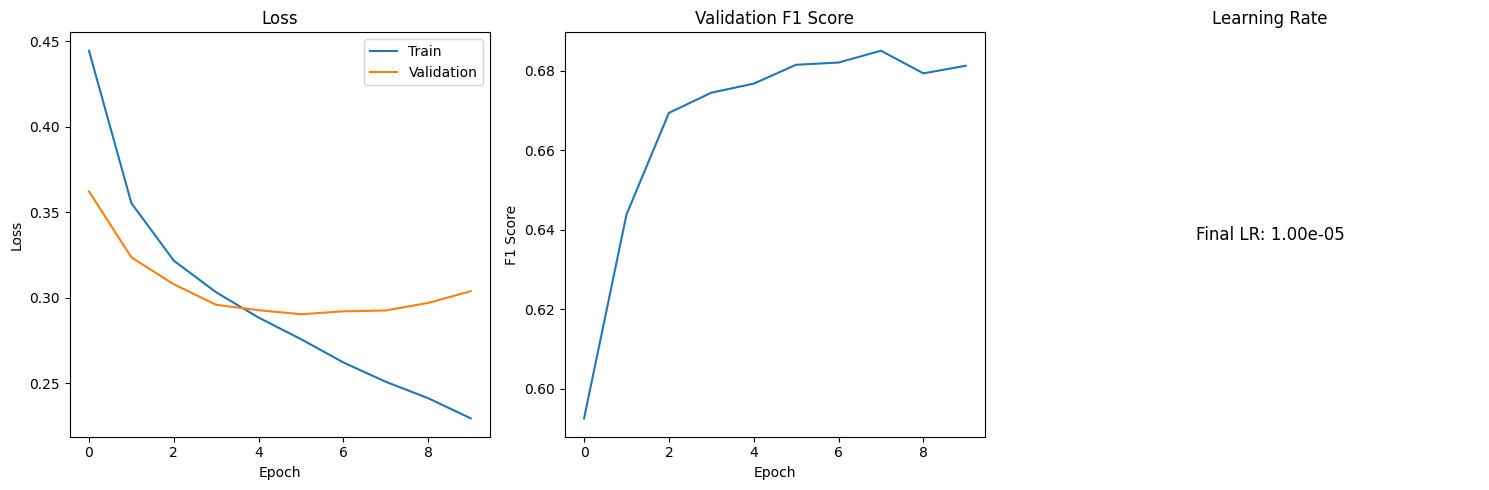

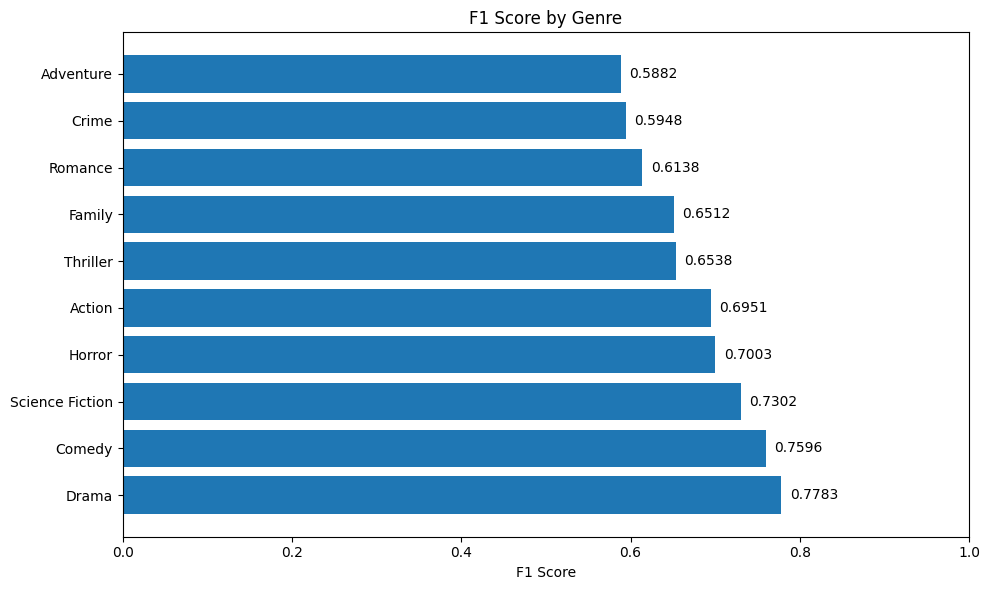

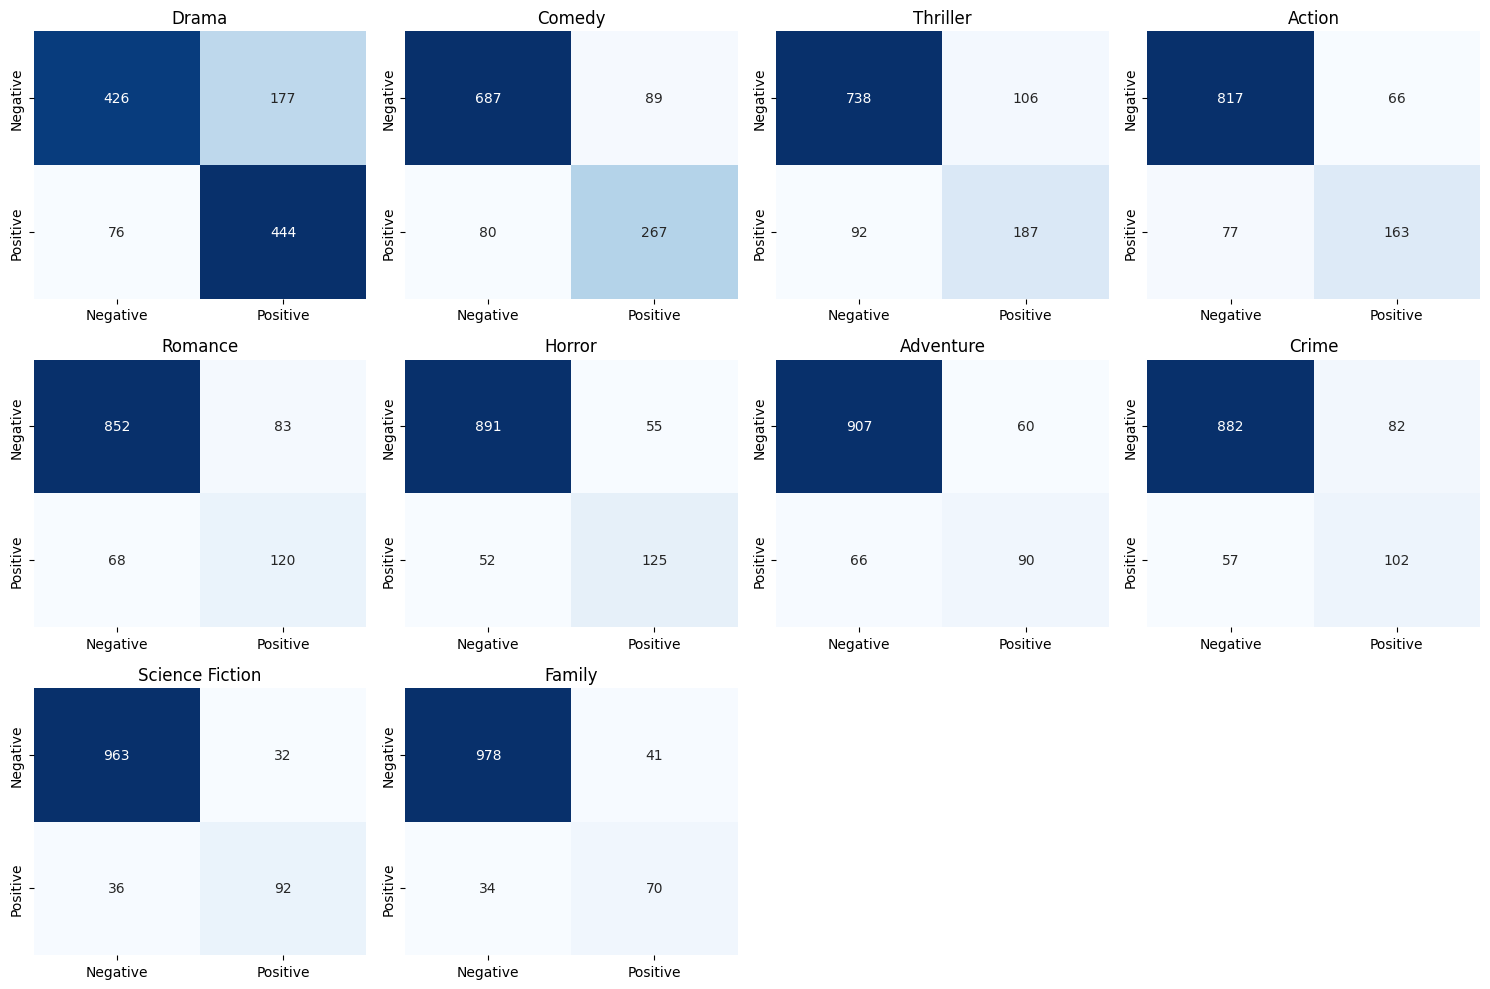

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import json
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import time

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("multimodal_classification.log"),
        logging.StreamHandler()
    ]
)

# Get the working directory
script_dir = os.getcwd()

# Set paths
base_dir = script_dir
data_dir = os.path.join(base_dir, "processed_data")
models_dir = os.path.join(base_dir, "models")
results_dir = os.path.join(base_dir, "results")

# Create directories
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(os.path.join(models_dir, "multimodal"), exist_ok=True)
os.makedirs(os.path.join(results_dir, "multimodal"), exist_ok=True)

# Define the top genres we want to classify
TOP_GENRES = [
    'Drama', 'Comedy', 'Thriller', 'Action', 'Romance',
    'Horror', 'Adventure', 'Crime', 'Science Fiction', 'Family'
]

#======= DATASET CLASS =======

class MultiModalMovieDataset(Dataset):


    def __init__(self, df, tokenizer, transform=None, max_length=128, label_to_idx=None):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Set image transform
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        # Get all possible genre labels
        if label_to_idx is None:
            # Extract all unique genres across the dataset
            all_genres = set()
            for genres_list in df['groups']:
                if isinstance(genres_list, list):
                    all_genres.update(genres_list)

            all_genres = sorted(list(all_genres))
            self.label_to_idx = {genre: i for i, genre in enumerate(all_genres)}
        else:
            self.label_to_idx = label_to_idx

        self.num_labels = len(self.label_to_idx)
        logging.info(f"Dataset initialized with {self.num_labels} possible labels")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Process text (overview)
        overview = row['overview'] if 'overview' in row and pd.notna(row['overview']) else ""
        encoding = self.tokenizer(
            overview,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Process image (poster)
        image_tensor = torch.zeros((3, 224, 224))  # Default empty tensor
        try:
            if 'poster_path' in row and pd.notna(row['poster_path']):
                img_path = row['poster_path']
                if os.path.exists(img_path):
                    img = Image.open(img_path).convert('RGB')
                    image_tensor = self.transform(img)
        except Exception as e:
            logging.warning(f"Error loading image for idx {idx}: {e}")

        # Create multi-hot encoded label vector
        label_vector = torch.zeros(self.num_labels)
        try:
            if isinstance(row['groups'], list):
                for genre in row['groups']:
                    if genre in self.label_to_idx:
                        label_vector[self.label_to_idx[genre]] = 1
        except KeyError:
            logging.warning(f"Groups not found for sample idx {idx}. Using empty label vector.")

        # Extract metadata features
        features = []
        for feature in ['vote_average', 'title_sentiment', 'overview_sentiment', 'title_length', 'overview_length']:
            if feature in row and pd.notna(row[feature]):
                features.append(float(row[feature]))
            else:
                features.append(0.0)

        metadata = torch.tensor(features, dtype=torch.float)

        return {
            'input_ids': encoding['input_ids'][0],
            'attention_mask': encoding['attention_mask'][0],
            'image': image_tensor,
            'metadata': metadata,
            'labels': label_vector
        }

#======= MODEL ARCHITECTURE =======

class MultiModalGenreClassifier(nn.Module):
    def __init__(self, num_genres, dropout=0.3):
        super().__init__()

        # Text encoder (BERT)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        bert_dim = self.bert.config.hidden_size  # 768

        # Freeze BERT layers to prevent overfitting
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze last few layers for fine-tuning
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

        # Image encoder (ResNet features)
        self.image_encoder = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
        # Remove the final classification layer
        self.image_encoder = nn.Sequential(*list(self.image_encoder.children())[:-1])
        image_dim = 512  # ResNet34 output dimension

        # Freeze image encoder layers
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        # Unfreeze last few layers
        for param in list(self.image_encoder.parameters())[-20:]:
            param.requires_grad = True

        # Metadata processing (5 features: vote_average, sentiments, lengths)
        metadata_dim = 5
        self.metadata_encoder = nn.Sequential(
            nn.Linear(metadata_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 64)
        )
        metadata_encoded_dim = 64

        # Fusion dimension
        fusion_dim = bert_dim + image_dim + metadata_encoded_dim

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_genres)
        )

    def forward(self, input_ids, attention_mask, image, metadata):
        # Text encoding
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output  # [batch_size, 768]

        # Image encoding
        image_features = self.image_encoder(image)
        image_features = image_features.squeeze(-1).squeeze(-1)  # [batch_size, 512]

        # Metadata encoding
        metadata_features = self.metadata_encoder(metadata)  # [batch_size, 64]

        # Concatenate features
        combined_features = torch.cat((text_features, image_features, metadata_features), dim=1)

        # Classification
        logits = self.classifier(combined_features)

        return logits



def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        # Get data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        metadata = batch['metadata'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(input_ids, attention_mask, images, metadata)

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device, threshold=0.5):
    model.eval()
    epoch_loss = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Get data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, images, metadata)

            # Calculate loss
            loss = criterion(logits, labels)

            # Make predictions
            predictions = (torch.sigmoid(logits) > threshold).float()

            # Update metrics
            epoch_loss += loss.item()

            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_labels, all_predictions, average='micro')

    return epoch_loss / len(dataloader), f1, all_predictions, all_labels



def train_multimodal_classifier():


    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Settings
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.01
    DROPOUT = 0.3
    N_EPOCHS = 10
    MAX_TEXT_LENGTH = 128
    THRESHOLD = 0.4

    # Select device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    logging.info(f"Using device: {device}")

    # Load data
    logging.info("Loading data...")
    try:
        train_df = pd.read_pickle(os.path.join(data_dir, "splits", "train.pkl"))
        val_df = pd.read_pickle(os.path.join(data_dir, "splits", "val.pkl"))
        test_df = pd.read_pickle(os.path.join(data_dir, "splits", "test.pkl"))
        logging.info(f"Loaded {len(train_df)} training, {len(val_df)} validation, and {len(test_df)} test samples")

        # Filter rows without posters (if necessary)
        train_df = train_df[train_df['poster_path'].notna()]
        val_df = val_df[val_df['poster_path'].notna()]
        test_df = test_df[test_df['poster_path'].notna()]

        logging.info(f"After filtering for posters: {len(train_df)} training, {len(val_df)} validation, and {len(test_df)} test samples")

        # Load or create genre mapping from the TOP_GENRES list
        label_to_idx = {genre: i for i, genre in enumerate(TOP_GENRES)}
        idx_to_label = {i: genre for i, genre in enumerate(TOP_GENRES)}

        logging.info(f"Using {len(label_to_idx)} genres: {list(label_to_idx.keys())}")

    except Exception as e:
        logging.error(f"Error loading data: {e}")
        import traceback
        logging.error(traceback.format_exc())
        return

    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create image transforms
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = MultiModalMovieDataset(
        train_df, tokenizer, transform=train_transform,
        max_length=MAX_TEXT_LENGTH, label_to_idx=label_to_idx
    )

    val_dataset = MultiModalMovieDataset(
        val_df, tokenizer, transform=val_transform,
        max_length=MAX_TEXT_LENGTH, label_to_idx=label_to_idx
    )

    test_dataset = MultiModalMovieDataset(
        test_df, tokenizer, transform=val_transform,
        max_length=MAX_TEXT_LENGTH, label_to_idx=label_to_idx
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=2 if torch.cuda.is_available() else 0, pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE,
        num_workers=2 if torch.cuda.is_available() else 0, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE,
        num_workers=2 if torch.cuda.is_available() else 0, pin_memory=True
    )

    # Create model
    logging.info("Creating multimodal classifier model...")
    model = MultiModalGenreClassifier(
        num_genres=len(label_to_idx),
        dropout=DROPOUT
    )

    # Move model to device
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logging.info(f"Model has {trainable_params:,} trainable parameters out of {total_params:,} total parameters")

    # Create loss function for multi-label classification
    criterion = nn.BCEWithLogitsLoss()

    # Create optimizer with different learning rates for different parts
    param_groups = [
        {'params': [p for n, p in model.bert.named_parameters() if p.requires_grad], 'lr': LEARNING_RATE / 10},
        {'params': [p for n, p in model.image_encoder.named_parameters() if p.requires_grad], 'lr': LEARNING_RATE / 10},
        {'params': [p for n, p in model.metadata_encoder.named_parameters()], 'lr': LEARNING_RATE},
        {'params': [p for n, p in model.classifier.named_parameters()], 'lr': LEARNING_RATE}
    ]

    optimizer = optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    # Training loop
    logging.info("Starting training...")
    best_val_f1 = 0.0
    best_model_state = None
    patience = 5
    patience_counter = 0

    # Track metrics
    train_losses = []
    val_losses = []
    val_f1s = []

    start_time = time.time()

    for epoch in range(N_EPOCHS):
        epoch_start = time.time()

        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)

        # Evaluate
        val_loss, val_f1, val_preds, val_labels = evaluate(
            model, val_loader, criterion, device, THRESHOLD
        )
        val_losses.append(val_loss)
        val_f1s.append(val_f1)

        epoch_time = time.time() - epoch_start

        # Log metrics
        logging.info(f"Epoch {epoch+1}/{N_EPOCHS} - Time: {epoch_time:.2f}s")
        logging.info(f"  Train Loss: {train_loss:.4f}")
        logging.info(f"  Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

        # Update learning rate based on validation F1
        scheduler.step(val_f1)

        # Save best model
        if val_f1 > best_val_f1:
            logging.info(f"  New best model! F1: {val_f1:.4f} (previous: {best_val_f1:.4f})")
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            logging.info(f"  No improvement for {patience_counter} epochs")

            if patience_counter >= patience:
                logging.info(f"Early stopping after {epoch+1} epochs")
                break

    total_time = time.time() - start_time
    logging.info(f"Training completed in {total_time:.2f}s")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Save best model
    torch.save(model.state_dict(), os.path.join(models_dir, "multimodal", "best_model.pt"))

    # Save genre mapping
    with open(os.path.join(models_dir, "multimodal", "genre_mapping.json"), 'w') as f:
        json.dump(label_to_idx, f, indent=2)

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_f1s)
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')

    plt.subplot(1, 3, 3)
    current_lr = optimizer.param_groups[0]['lr']
    plt.text(0.5, 0.5, f"Final LR: {current_lr:.2e}", ha='center', va='center', fontsize=12)
    plt.title('Learning Rate')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "multimodal", "training_curves.png"))

    # Evaluate on test set
    logging.info("Evaluating on test set...")
    test_loss, test_f1, test_preds, test_labels = evaluate(
        model, test_loader, criterion, device, THRESHOLD
    )

    logging.info(f"Test Loss: {test_loss:.4f}")
    logging.info(f"Test F1 Score: {test_f1:.4f}")

    # Calculate per-class F1 scores
    per_class_f1 = f1_score(test_labels, test_preds, average=None)

    # Log per-class F1 scores
    logging.info("Per-class F1 scores:")
    class_metrics = {}
    for i, f1 in enumerate(per_class_f1):
        genre = idx_to_label[i]
        support = np.sum(np.array(test_labels)[:, i])
        logging.info(f"  {genre}: F1={f1:.4f}, Support={support}")
        class_metrics[genre] = {"f1": float(f1), "support": int(support)}

    # Save results
    results = {
        "test_f1": float(test_f1),
        "per_class_metrics": class_metrics,
        "train_time": float(total_time),
        "best_val_f1": float(best_val_f1),
        "threshold": float(THRESHOLD)
    }

    with open(os.path.join(results_dir, "multimodal", "test_results.json"), 'w') as f:
        json.dump(results, f, indent=2)

    # Plot per-class F1 scores
    plt.figure(figsize=(10, 6))
    genres = []
    f1_scores = []

    for genre, metrics in sorted(class_metrics.items(), key=lambda x: x[1]['f1'], reverse=True):
        genres.append(genre)
        f1_scores.append(metrics['f1'])

    plt.barh(genres, f1_scores)
    plt.xlabel('F1 Score')
    plt.title('F1 Score by Genre')
    plt.xlim(0, 1.0)

    # Add values on bars
    for i, v in enumerate(f1_scores):
        plt.text(v + 0.01, i, f"{v:.4f}", va='center')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "multimodal", "per_class_f1.png"))

    # Generate confusion matrix for each class
    test_preds_array = np.array(test_preds)
    test_labels_array = np.array(test_labels)

    plt.figure(figsize=(15, 10))
    for i, genre in enumerate(TOP_GENRES):
        plt.subplot(3, 4, i+1)

        # Calculate confusion matrix values
        tp = np.sum((test_preds_array[:, i] == 1) & (test_labels_array[:, i] == 1))
        fp = np.sum((test_preds_array[:, i] == 1) & (test_labels_array[:, i] == 0))
        fn = np.sum((test_preds_array[:, i] == 0) & (test_labels_array[:, i] == 1))
        tn = np.sum((test_preds_array[:, i] == 0) & (test_labels_array[:, i] == 0))

        cm = np.array([[tn, fp], [fn, tp]])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])

        plt.title(f'{genre}')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "multimodal", "confusion_matrices.png"))

    return model, results

if __name__ == "__main__":
    train_multimodal_classifier()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Getting probabilities: 100%|██████████| 71/71 [00:07<00:00,  9.82it/s]


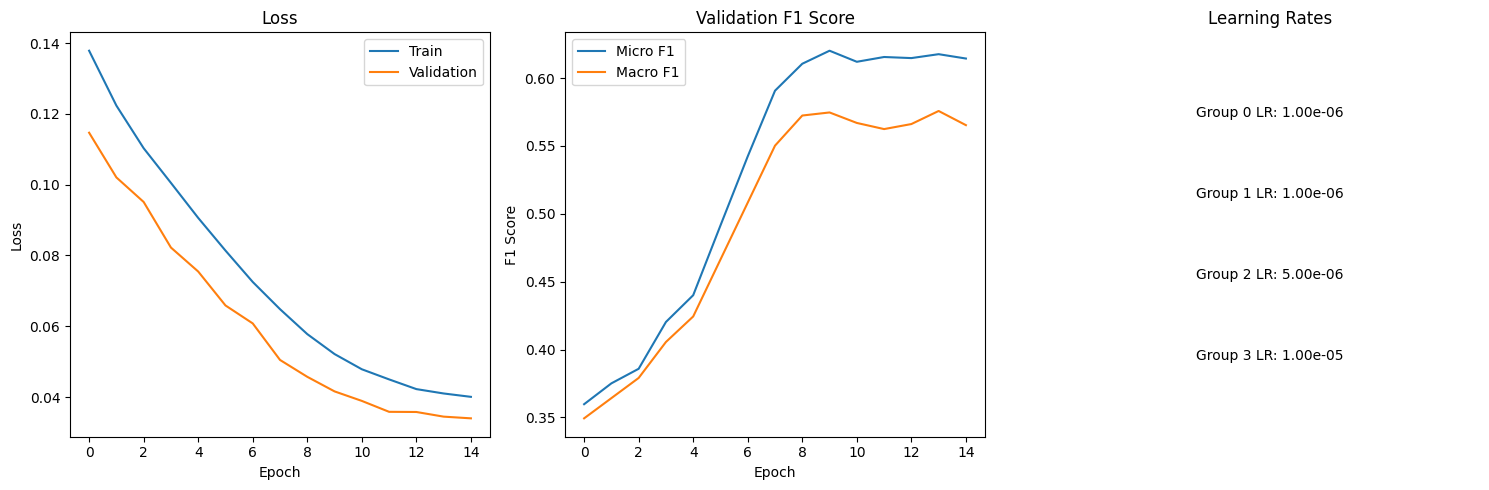

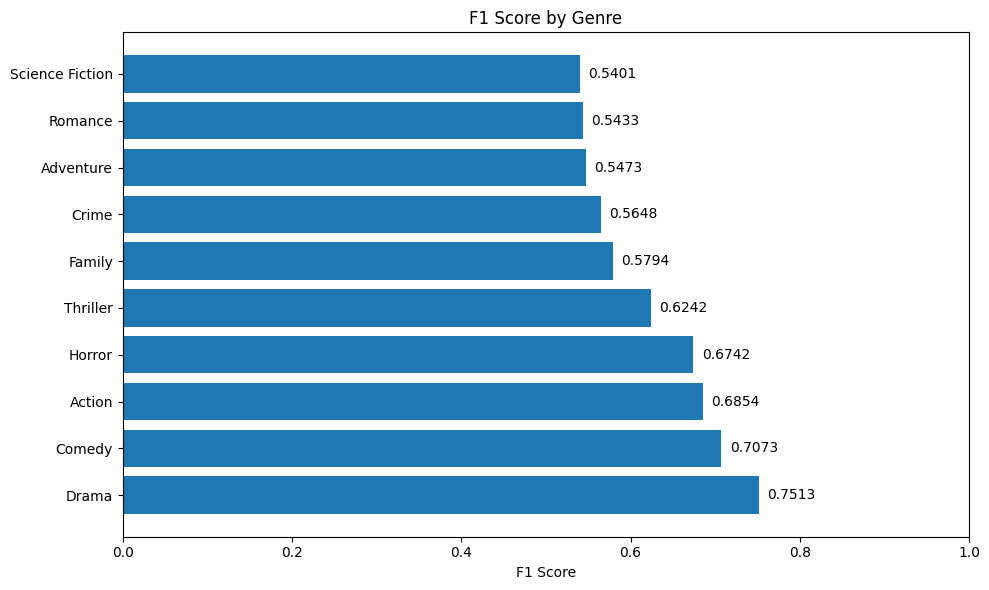

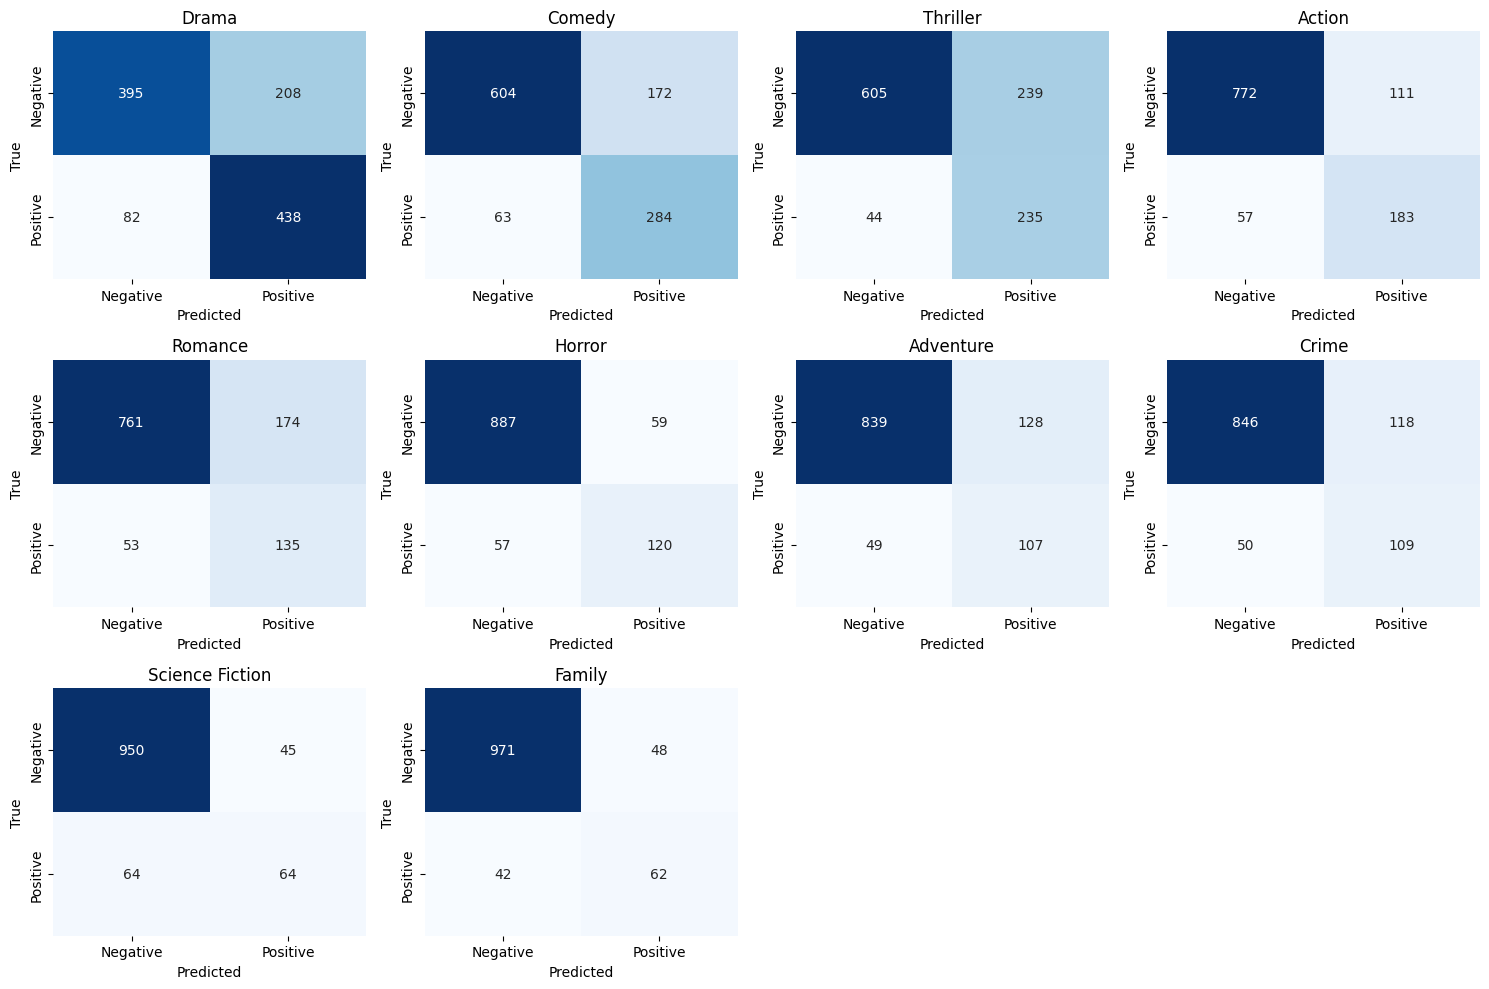

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import json
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from transformers import BertTokenizer, BertModel
from torchvision.models import resnet34
from tqdm import tqdm
import time

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("fusion_model.log"),
        logging.StreamHandler()
    ]
)

# Get the directory where the script is located
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If running in a notebook
    script_dir = os.getcwd()

# Set paths
base_dir = script_dir
data_dir = os.path.join(base_dir, "processed_data")
models_dir = os.path.join(base_dir, "models")
results_dir = os.path.join(base_dir, "results")

# Create directories
os.makedirs(os.path.join(models_dir, "fusion"), exist_ok=True)
os.makedirs(os.path.join(results_dir, "fusion"), exist_ok=True)


class FusionDataset(Dataset):

    def __init__(self, df, tokenizer, transform=None, max_length=128, label_to_idx=None):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Set up image transforms
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        # Get label mapping
        if label_to_idx is None:
            # Extract all unique genres
            all_genres = set()
            for genres_list in df['groups']:
                if isinstance(genres_list, list):
                    all_genres.update(genres_list)

            all_genres = sorted(list(all_genres))
            self.label_to_idx = {genre: i for i, genre in enumerate(all_genres)}
        else:
            self.label_to_idx = label_to_idx

        self.num_labels = len(self.label_to_idx)
        logging.info(f"Dataset initialized with {self.num_labels} possible labels")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Process text
        text = row['overview'] if 'overview' in row and pd.notna(row['overview']) else ""
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Process image
        image_tensor = torch.zeros((3, 224, 224))  # Default empty tensor
        try:
            if 'poster_path' in row and pd.notna(row['poster_path']):
                img_path = row['poster_path']
                if os.path.exists(img_path):
                    img = Image.open(img_path).convert('RGB')
                    image_tensor = self.transform(img)
        except Exception as e:
            logging.warning(f"Error loading image for idx {idx}: {e}")

        # Create label vector
        label_vector = torch.zeros(self.num_labels)
        try:
            if isinstance(row['groups'], list):
                for genre in row['groups']:
                    if genre in self.label_to_idx:
                        label_vector[self.label_to_idx[genre]] = 1
        except KeyError:
            logging.warning(f"Groups not found for sample idx {idx}. Using empty label vector.")

        # Extract additional features
        metadata = []
        for feature in ['vote_average', 'title_sentiment', 'overview_sentiment']:
            if feature in row and pd.notna(row[feature]):
                metadata.append(float(row[feature]))
            else:
                metadata.append(0.0)

        metadata_tensor = torch.tensor(metadata, dtype=torch.float)

        return {
            'input_ids': encoding['input_ids'][0],
            'attention_mask': encoding['attention_mask'][0],
            'image': image_tensor,
            'metadata': metadata_tensor,
            'labels': label_vector
        }



class TextEncoder(nn.Module):

    def __init__(self, freeze_bert=True):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freeze BERT layers to prevent overfitting
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

            # Unfreeze only the last 2 layers for fine-tuning
            for param in self.bert.encoder.layer[-2:].parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output  # [batch_size, 768]

class ImageEncoder(nn.Module):

    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pretrained ResNet34
        self.backbone = resnet34(pretrained=True)

        # Remove classification layer
        self.features = nn.Sequential(*list(self.backbone.children())[:-1])

        # Freeze backbone
        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False

            # Unfreeze last few layers
            layers_to_unfreeze = list(self.features.children())[-3:]
            for layer in layers_to_unfreeze:
                for param in layer.parameters():
                    param.requires_grad = True

    def forward(self, x):
        features = self.features(x)
        features = features.view(features.size(0), -1)  # Flatten: [batch_size, 512]
        return features

class FusionModel(nn.Module):

    def __init__(self, num_genres, dropout=0.3):
        super().__init__()

        # Text and image encoders
        self.text_encoder = TextEncoder(freeze_bert=True)
        self.image_encoder = ImageEncoder(freeze_backbone=True)

        # Dimensions
        text_dim = 768  # BERT output
        image_dim = 512  # ResNet34 output
        metadata_dim = 3  # vote_average, title_sentiment, overview_sentiment

        # Metadata processor
        self.metadata_processor = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Feature fusion - combine all modalities
        fusion_input_dim = text_dim + image_dim + 64  # Text + Image + Metadata

        # Attention mechanism for feature importance
        self.attention = nn.Sequential(
            nn.Linear(fusion_input_dim, fusion_input_dim // 4),
            nn.ReLU(),
            nn.Linear(fusion_input_dim // 4, fusion_input_dim),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(fusion_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_genres)
        )

    def forward(self, input_ids, attention_mask, image, metadata):
        # Extract features from each modality
        text_features = self.text_encoder(input_ids, attention_mask)
        image_features = self.image_encoder(image)
        metadata_features = self.metadata_processor(metadata)

        # Concatenate features
        combined = torch.cat([text_features, image_features, metadata_features], dim=1)

        # Apply attention to weight features based on importance
        attention_weights = self.attention(combined)
        attended_features = combined * attention_weights

        # Classification
        logits = self.classifier(attended_features)

        return logits

class FocalLoss(nn.Module):

    def __init__(self, gamma=2.0, alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)
        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0

        # Apply weights to each class
        alpha_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Apply gamma focusing parameter
        focal_loss = alpha_weight * (1 - pt) ** self.gamma * BCE_loss

        return focal_loss.mean()



def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Get data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        metadata = batch['metadata'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(input_ids, attention_mask, images, metadata)

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device, threshold=0.4):
    model.eval()
    epoch_loss = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Get data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, images, metadata)

            # Calculate loss
            loss = criterion(logits, labels)

            # Convert logits to predictions
            predictions = (torch.sigmoid(logits) > threshold).float()

            # Update metrics
            epoch_loss += loss.item()

            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1 score
    f1_micro = f1_score(all_labels, all_predictions, average='micro')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')

    return epoch_loss / len(dataloader), f1_micro, f1_macro, all_predictions, all_labels

def optimize_threshold(model, dataloader, device, thresholds=None):
    model.eval()

    all_labels = []
    all_probs = []

    if thresholds is None:
        num_classes = next(iter(dataloader))['labels'].shape[1]
        thresholds = [0.5] * num_classes

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Finding optimal thresholds"):
            # Get data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, images, metadata)
            probs = torch.sigmoid(logits)

            # Store
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    labels_array = np.array(all_labels)
    probs_array = np.array(all_probs)

    # Find optimal threshold for each class
    optimal_thresholds = []

    for i in range(labels_array.shape[1]):
        best_f1 = 0
        best_threshold = 0.5

        # Try different thresholds
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs_array[:, i] > threshold).astype(float)
            f1 = f1_score(labels_array[:, i], preds, zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        optimal_thresholds.append(best_threshold)

    return optimal_thresholds

def train_fusion_model():

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Settings
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 0.01
    DROPOUT = 0.3
    N_EPOCHS = 15
    MAX_TEXT_LENGTH = 128
    PATIENCE = 5  # Early stopping patience

    # Select device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    logging.info(f"Using device: {device}")

    # Load data
    logging.info("Loading data...")
    try:
        train_df = pd.read_pickle(os.path.join(data_dir, "splits", "train.pkl"))
        val_df = pd.read_pickle(os.path.join(data_dir, "splits", "val.pkl"))
        test_df = pd.read_pickle(os.path.join(data_dir, "splits", "test.pkl"))
        logging.info(f"Loaded {len(train_df)} training, {len(val_df)} validation, and {len(test_df)} test samples")

        # Filter rows without posters
        train_df = train_df[train_df['poster_path'].notna()]
        val_df = val_df[val_df['poster_path'].notna()]
        test_df = test_df[test_df['poster_path'].notna()]

        logging.info(f"After filtering for posters: {len(train_df)} training, {len(val_df)} validation, and {len(test_df)} test samples")

        # Load or create genre mapping
        try:
            with open(os.path.join(data_dir, "genre_mapping.json"), 'r') as f:
                genre_mapping = json.load(f)
                label_to_idx = genre_mapping
                idx_to_label = {int(idx): label for label, idx in genre_mapping.items()}
        except:
            # Define the top genres we want to classify
            TOP_GENRES = [
                'Drama', 'Comedy', 'Thriller', 'Action', 'Romance',
                'Horror', 'Adventure', 'Crime', 'Science Fiction', 'Family'
            ]

            label_to_idx = {genre: i for i, genre in enumerate(TOP_GENRES)}
            idx_to_label = {i: genre for i, genre in enumerate(TOP_GENRES)}

            # Save mapping
            with open(os.path.join(models_dir, "fusion", "genre_mapping.json"), 'w') as f:
                json.dump(label_to_idx, f, indent=2)

        logging.info(f"Using {len(label_to_idx)} genres: {list(label_to_idx.keys())}")

    except Exception as e:
        logging.error(f"Error loading data: {e}")
        import traceback
        logging.error(traceback.format_exc())
        return

    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = FusionDataset(
        train_df, tokenizer, transform=train_transform,
        max_length=MAX_TEXT_LENGTH, label_to_idx=label_to_idx
    )

    val_dataset = FusionDataset(
        val_df, tokenizer, transform=val_transform,
        max_length=MAX_TEXT_LENGTH, label_to_idx=label_to_idx
    )

    test_dataset = FusionDataset(
        test_df, tokenizer, transform=val_transform,
        max_length=MAX_TEXT_LENGTH, label_to_idx=label_to_idx
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=2 if torch.cuda.is_available() else 0, pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE,
        num_workers=2 if torch.cuda.is_available() else 0, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE,
        num_workers=2 if torch.cuda.is_available() else 0, pin_memory=True
    )

    # Create model
    logging.info("Creating fusion model...")
    model = FusionModel(
        num_genres=len(label_to_idx),
        dropout=DROPOUT
    )

    # Move model to device
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logging.info(f"Model has {trainable_params:,} trainable parameters out of {total_params:,} total parameters")
    logging.info(f"Percentage trainable: {trainable_params/total_params*100:.2f}%")

    # Create loss function
    criterion = FocalLoss(gamma=2.0, alpha=0.25)

    param_groups = [
        # Text encoder - lowest LR
        {'params': [p for n, p in model.text_encoder.named_parameters() if p.requires_grad],
         'lr': LEARNING_RATE / 10},
        # Image encoder - lowest LR
        {'params': [p for n, p in model.image_encoder.named_parameters() if p.requires_grad],
         'lr': LEARNING_RATE / 10},
        # Metadata processor - mid LR
        {'params': model.metadata_processor.parameters(),
         'lr': LEARNING_RATE / 2},
        # Attention and classifier - highest LR
        {'params': list(model.attention.parameters()) + list(model.classifier.parameters()),
         'lr': LEARNING_RATE}
    ]

    optimizer = optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    # Training loop
    logging.info("Starting training...")
    start_time = time.time()

    best_val_f1 = 0.0
    best_model_state = None
    patience_counter = 0

    # Track metrics
    train_losses = []
    val_losses = []
    val_f1s_micro = []
    val_f1s_macro = []

    for epoch in range(N_EPOCHS):
        epoch_start = time.time()

        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)

        # Evaluate
        val_loss, val_f1_micro, val_f1_macro, val_preds, val_labels = evaluate(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        val_f1s_micro.append(val_f1_micro)
        val_f1s_macro.append(val_f1_macro)

        epoch_time = time.time() - epoch_start

        # Log metrics
        logging.info(f"Epoch {epoch+1}/{N_EPOCHS} - Time: {epoch_time:.2f}s")
        logging.info(f"  Train Loss: {train_loss:.4f}")
        logging.info(f"  Val Loss: {val_loss:.4f}, Val F1 (micro): {val_f1_micro:.4f}, Val F1 (macro): {val_f1_macro:.4f}")

        # Update learning rate based on validation F1
        scheduler.step(val_f1_micro)

        # Save best model
        if val_f1_micro > best_val_f1:
            logging.info(f"  New best model! F1: {val_f1_micro:.4f} (previous: {best_val_f1:.4f})")
            best_val_f1 = val_f1_micro
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            logging.info(f"  No improvement for {patience_counter} epochs")

            if patience_counter >= PATIENCE:
                logging.info(f"Early stopping after {epoch+1} epochs")
                break

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), os.path.join(models_dir, "fusion", f"checkpoint_epoch_{epoch+1}.pt"))

    total_time = time.time() - start_time
    logging.info(f"Training completed in {total_time:.2f}s")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Save best model
    torch.save(model.state_dict(), os.path.join(models_dir, "fusion", "best_model.pt"))

    # Save genre mapping
    with open(os.path.join(models_dir, "fusion", "genre_mapping.json"), 'w') as f:
        json.dump(label_to_idx, f, indent=2)

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_f1s_micro, label='Micro F1')
    plt.plot(val_f1s_macro, label='Macro F1')
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.subplot(1, 3, 3)
    for i, group in enumerate(optimizer.param_groups):
        plt.text(0.5, 0.8-i*0.2, f"Group {i} LR: {group['lr']:.2e}", ha='center', va='center', fontsize=10)
    plt.title('Learning Rates')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "fusion", "training_curves.png"))

    # Find optimal thresholds
    logging.info("Finding optimal thresholds for each class...")
    optimal_thresholds = optimize_threshold(model, val_loader, device)

    threshold_dict = {idx_to_label[i]: float(thresh) for i, thresh in enumerate(optimal_thresholds)}
    logging.info(f"Optimal thresholds: {threshold_dict}")

    # Save thresholds
    with open(os.path.join(models_dir, "fusion", "optimal_thresholds.json"), 'w') as f:
        json.dump(threshold_dict, f, indent=2)

    # Evaluate on test set with optimal thresholds
    logging.info("Evaluating on test set with optimal thresholds...")
    test_loss, test_f1_micro, test_f1_macro, test_preds, test_labels = evaluate(
        model, test_loader, criterion, device, threshold=0.4  # Default threshold - will use class-specific below
    )

    # Apply optimal thresholds to raw probabilities
    test_probs = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Getting probabilities"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)

            logits = model(input_ids, attention_mask, images, metadata)
            probs = torch.sigmoid(logits)
            test_probs.extend(probs.cpu().numpy())

    # Apply class-specific thresholds
    test_probs_array = np.array(test_probs)
    test_labels_array = np.array(test_labels)

    # Apply optimal thresholds
    thresholded_preds = np.zeros_like(test_probs_array)
    for i, threshold in enumerate(optimal_thresholds):
        thresholded_preds[:, i] = (test_probs_array[:, i] > threshold).astype(float)

    # Calculate metrics with optimal thresholds
    test_f1_micro_opt = f1_score(test_labels_array, thresholded_preds, average='micro')
    test_f1_macro_opt = f1_score(test_labels_array, thresholded_preds, average='macro')

    logging.info(f"Test Results:")
    logging.info(f"  Loss: {test_loss:.4f}")
    logging.info(f"  F1 (micro) with default threshold: {test_f1_micro:.4f}")
    logging.info(f"  F1 (micro) with optimal thresholds: {test_f1_micro_opt:.4f}")
    logging.info(f"  F1 (macro) with optimal thresholds: {test_f1_macro_opt:.4f}")

    # Calculate per-class F1 scores
    per_class_f1 = f1_score(test_labels_array, thresholded_preds, average=None)

    # Log per-class F1 scores
    logging.info("Per-class F1 scores:")
    class_metrics = {}
    for i, f1 in enumerate(per_class_f1):
        genre = idx_to_label[i]
        support = np.sum(test_labels_array[:, i])
        threshold = optimal_thresholds[i]
        logging.info(f"  {genre}: F1={f1:.4f}, Support={support}, Threshold={threshold:.4f}")
        class_metrics[genre] = {"f1": float(f1), "support": int(support), "threshold": float(threshold)}

    # Save results
    results = {
        "test_f1_micro": float(test_f1_micro_opt),
        "test_f1_macro": float(test_f1_macro_opt),
        "train_time": float(total_time),
        "best_val_f1": float(best_val_f1),
        "per_class_metrics": class_metrics
    }

    with open(os.path.join(results_dir, "fusion", "test_results.json"), 'w') as f:
        json.dump(results, f, indent=2)

    # Plot per-class F1 scores
    plt.figure(figsize=(10, 6))
    genres = []
    f1_scores = []

    for genre, metrics in sorted(class_metrics.items(), key=lambda x: x[1]['f1'], reverse=True):
        genres.append(genre)
        f1_scores.append(metrics['f1'])

    plt.barh(genres, f1_scores)
    plt.xlabel('F1 Score')
    plt.title('F1 Score by Genre')
    plt.xlim(0, 1.0)

    # Add values on bars
    for i, v in enumerate(f1_scores):
        plt.text(v + 0.01, i, f"{v:.4f}", va='center')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "fusion", "per_class_f1.png"))

    # Create confusion matrices for each genre
    plt.figure(figsize=(15, 10))

    # Plot 3x4 grid of confusion matrices
    rows, cols = 3, 4  # Adjust as needed

    for i, genre in enumerate(label_to_idx.keys()):
        if i >= rows * cols:
            break

        class_idx = label_to_idx[genre]
        y_true = test_labels_array[:, class_idx]
        y_pred = thresholded_preds[:, class_idx]

        # Create confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        plt.subplot(rows, cols, i + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])

        plt.title(f'{genre}')
        plt.xlabel('Predicted')
        plt.ylabel('True')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "fusion", "confusion_matrices.png"))

    return model, results

if __name__ == "__main__":
    train_fusion_model()